In [128]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

In [129]:
# import functions from modsim

from modsim import *

In [130]:
from modsim import State, System, TimeSeries, linrange, linspace, SweepSeries


In [131]:
def make_tea_system(T_init, volume, r, t_end):
    return System(T_init=T_init,
                  T_final=T_init,
                  volume=volume,
                  r=r,
                  t_end=t_end,
                  T_env=22,  # Ambient temperature
                  t_0=0,
                  dt=1)

In [132]:
def run_tea_simulation(system, change_func):
    t_array = linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)

    series = TimeSeries(index=t_array)
    series.iloc[0] = system.T_init

    for i in range(n - 1):
        t = t_array[i]
        T = series.iloc[i]
        series.iloc[i + 1] = T + change_func(t, T, system)

    system.T_final = series.iloc[-1]
    return series

In [133]:
def tea_change_func(t, T, system):
    r, T_env, dt = system.r, system.T_env, system.dt
    return -r * (T - T_env) * dt

In [134]:
def mix_tea(system1, system2):
    V1, V2 = system1.volume, system2.volume
    T1, T2 = system1.T_final, system2.T_final

    V_mix = V1 + V2
    T_mix = (V1 * T1 + V2 * T2) / V_mix

    return make_tea_system(T_init=T_mix,
                           volume=V_mix,
                           r=system1.r,
                           t_end=30)


In [135]:
def sweep_mixing_time(system1, system2):
    sweep = SweepSeries()

    for t_add in linspace(0, 30, 11):
        mixture = mix_tea(system1, system2)
        mixture.t_end = 30 - t_add
        run_tea_simulation(mixture, tea_change_func)
        sweep[t_add] = mixture.T_final

    return sweep

In [136]:
r_tea = 0.0115
tea = make_tea_system(T_init=90, volume=300, r=r_tea, t_end=30)
results_tea = run_tea_simulation(tea, tea_change_func)

In [137]:
r_milk = 0.133  # Replace with the appropriate value
milk = make_tea_system(T_init=5, volume=50, r=r_milk, t_end=15)
results_milk = run_tea_simulation(milk, tea_change_func)

In [138]:
mix_first_tea = mix_tea(tea, milk)
run_tea_simulation(mix_first_tea, tea_change_func)
print("Temperature after mixing at the beginning:", mix_first_tea.T_final)

Temperature after mixing at the beginning: 50.916259454305184


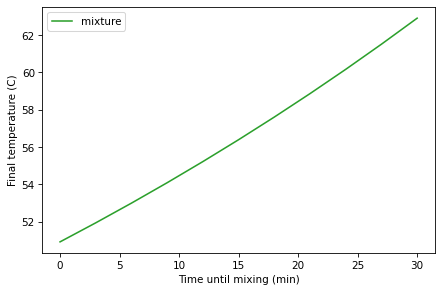

In [139]:
sweep_results = sweep_mixing_time(tea, milk)

# Plotting the results
sweep_results.plot(label='mixture', color='C2')
decorate(xlabel='Time until mixing (min)',
         ylabel='Final temperature (C)')